# Determining Causal Graph from Binary Structure Tests

In [19]:
import sys
sys.path.insert(0, '../..')

In [20]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import trange as tnrange
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout

from cs330.data_generators.multivariate_categorical import MultiCategorical
from cs330.data_generators.causal_graph import CausalGraph
from cs330.models.augmented_binary_models import *
from cs330.models.augmented_binary_model_trainer import *

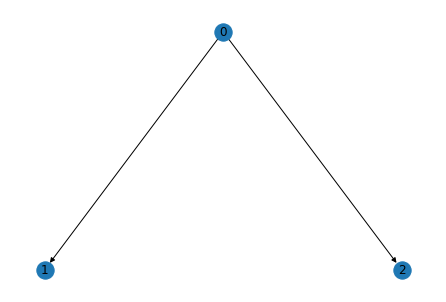

In [21]:
# Set up graph

N = 10
M = 3

data_gen = MultiCategorical(N, M)
data_gen.graph.B = np.array([
    [0, 0, 0],
    [1, 0, 0],
    [1, 0, 0]
])

# Visualize
data_gen.graph.visualize()

In [22]:
# Choose model type to test pairwise binary connections

BINARY_MODEL_TYPE = CauseOnlyBinaryStructureModel

In [23]:
# Binary Test Training Constants
INNER_LR = 1e-1
OUTER_LR = 1e-2
TRANSFER_EPISODE_COUNT = 500
TRANSFER_EPISODE_GRADIENT_STEPS = 20
TRANSFER_EPISODE_BATCH_SIZE = 50
PRETRAIN_EPISODE_BATCH_SIZE = 500

In [24]:
# Iterate through all node pairs and save resulting predicted structures
structure_predictions = {}
for A in tnrange(M - 1):
    for B in tnrange(A + 1, M, leave=False):
        model = BINARY_MODEL_TYPE(N, M, A, B)
        model_handler = AugmentedBinaryModelTrainer(
            data_gen, model,
            inner_lr = INNER_LR,
            outer_lr = OUTER_LR,
            transfer_episode_count = TRANSFER_EPISODE_COUNT,
            transfer_episode_gradient_steps = TRANSFER_EPISODE_GRADIENT_STEPS,
            transfer_episode_batch_size = TRANSFER_EPISODE_BATCH_SIZE,
            pretrain_episode_batch_size = PRETRAIN_EPISODE_BATCH_SIZE
        )

        # Meta-learn structure
        model_handler.train_structure()

        # Save resulting structure prediction
        structure_predictions[(A, B)] = {
            name: prob for name, prob in zip(model.hypothesis_names(), model.structure_likelihoods().tolist())
        }

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [25]:
structure_predictions

{(0, 1): {'A -> B': 0.9001306891441345, 'B -> A': 0.09986931085586548},
 (0, 2): {'A -> B': 0.7995274662971497, 'B -> A': 0.20047251880168915},
 (1, 2): {'A -> B': 0.6026974320411682, 'B -> A': 0.397302508354187}}

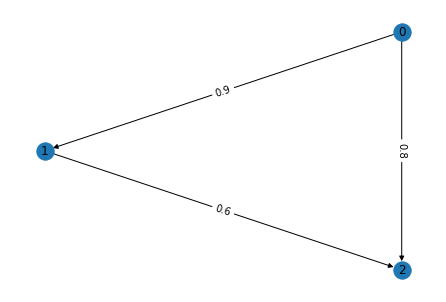

In [26]:
# Visualize graph resulting from these predictions
predicted_graph = nx.DiGraph()
for (A, B), binary_structure in structure_predictions.items():
    max_structure_prob = max(*binary_structure.values())
    if binary_structure['A -> B'] == max_structure_prob:
        predicted_graph.add_edge(A, B, weight = round(binary_structure['A -> B'], 2))
    elif binary_structure['B -> A'] == max_structure_prob:
        predicted_graph.add_edge(B, A, weight = round(binary_structure['B -> A'], 2))

pos = graphviz_layout(predicted_graph, prog='dot')
edge_labels = nx.get_edge_attributes(predicted_graph, 'weight')
nx.draw(predicted_graph, with_labels = True, pos = pos)
nx.draw_networkx_edge_labels(predicted_graph, pos, edge_labels = edge_labels)
plt.show()